# Прогнозирование температуры звезды

## Описание проекта

<b><u>Цель:</u></b> с помощью нейросети определять температуру на поверхности обнаруженных звёзд

<b><u>Задача:</u></b> необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

<b><u>План действий:</u></b> 
1. Загрузка исходных данных из файла
2. Исследовательский анализ
3. Подготовка данных к построению модели
4. Построение простой модели нейронной сети — baseline
5. Улучшение сети
6. Выводы по проекту

## Загрузка данных

In [114]:
#!pip install phik
#!pip install scikit-learn -U

In [115]:
#pip freeze

In [116]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import root_mean_squared_error
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
RANDOM_STATE = 42

In [117]:
project_path_01 = "C:\\Users\\kushn\\Documents\\Python_trainings\\Yandex_DS\\PyTorch\\"
project_path_02 = "/datasets/"

In [118]:
if os.path.exists(project_path_01):
    raw_data = pd.read_csv(project_path_01 + '6_class.csv')
elif os.path.exists(project_path_02):
    raw_data = pd.read_csv(project_path_02 + '6_class.csv')
else:
    print('Smth wrong')

In [119]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [120]:
raw_data.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


### Предобработка

проверим полные дубли

In [121]:
raw_data.duplicated().sum()

0

удалим столбец 'Unnamed: 0'

In [122]:
raw_data.drop(columns="Unnamed: 0", inplace=True)

переименуем столбцы

In [123]:
raw_data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [124]:
raw_data = raw_data.rename(columns={'Temperature (K)':'temperature',
                                    'Luminosity(L/Lo)':'luminosity',
                                    'Radius(R/Ro)':'radius',
                                    'Absolute magnitude(Mv)':'absolute_magnitude',
                                    'Star type':'star_type',
                                    'Star color':'star_color'})

In [125]:
raw_data.columns

Index(['temperature', 'luminosity', 'radius', 'absolute_magnitude',
       'star_type', 'star_color'],
      dtype='object')

In [126]:
df = raw_data

### Выводы по первичным данным
- таблица 7х240
- удалили столбец "Unnamed: 0", таблица 6х240
- переименовали столбцы в снейк_кейс
- полных дублей нет
- нулевых данных нет

## EDA

In [127]:
def graph (column, df=df):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    sns.histplot(df[column], ax=axes[0])
    sns.boxplot(x=df[column], ax=axes[1])
    axes[0].set_title('Гистограмма показателя ' + column)
    axes[1].set_title('Боксплот показателя ' + column)
    plt.tight_layout()
    plt.show()

### температура

In [128]:
df.temperature.describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64

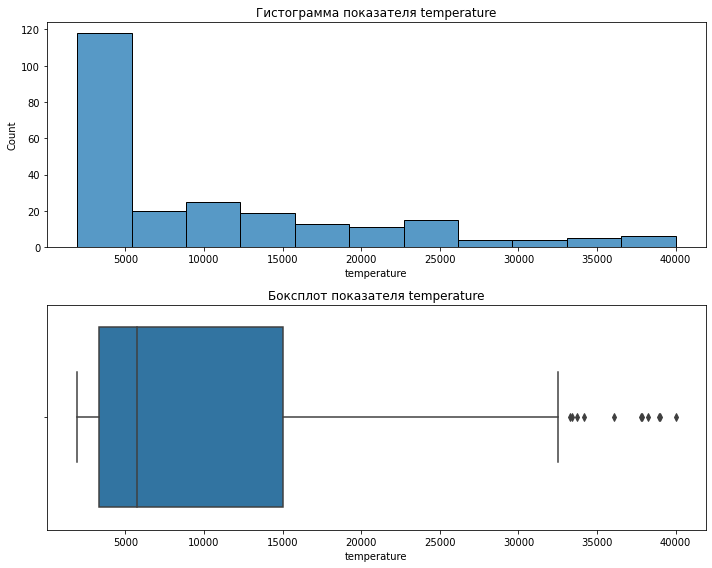

In [129]:
graph('temperature')

### luminosity

In [130]:
df.luminosity.describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64

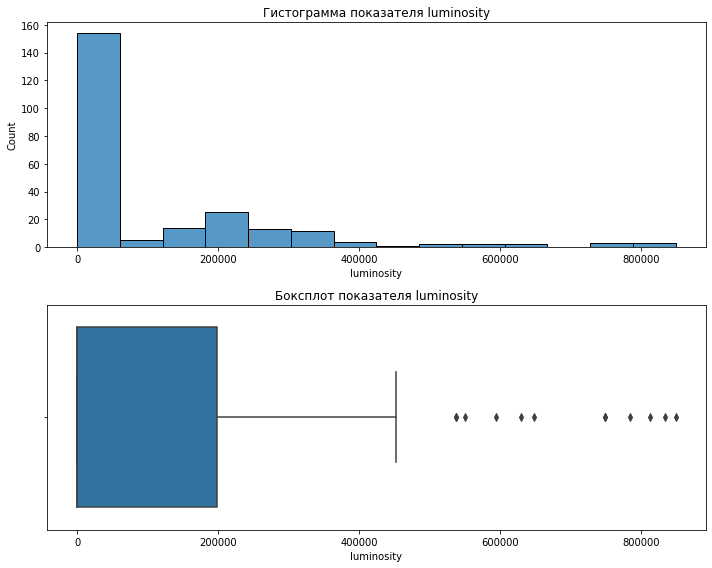

In [131]:
graph('luminosity')

### radius

In [132]:
df.radius.describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

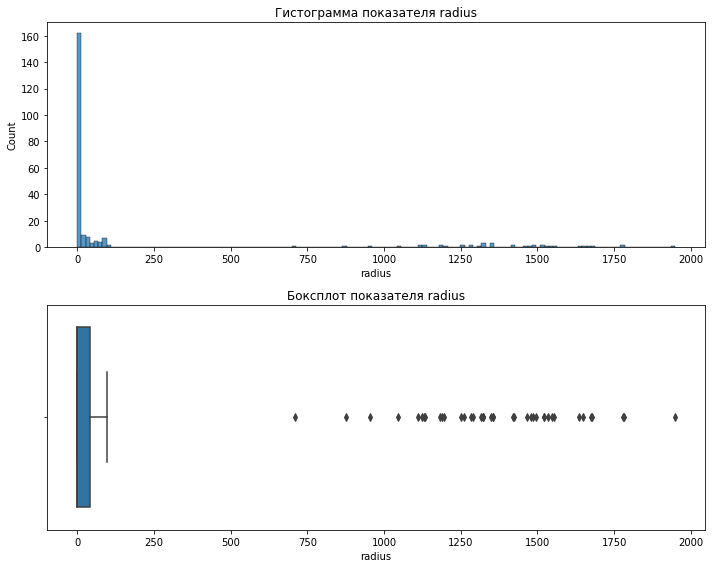

In [133]:
graph('radius')

### absolute_magnitude

In [134]:
df.absolute_magnitude.describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64

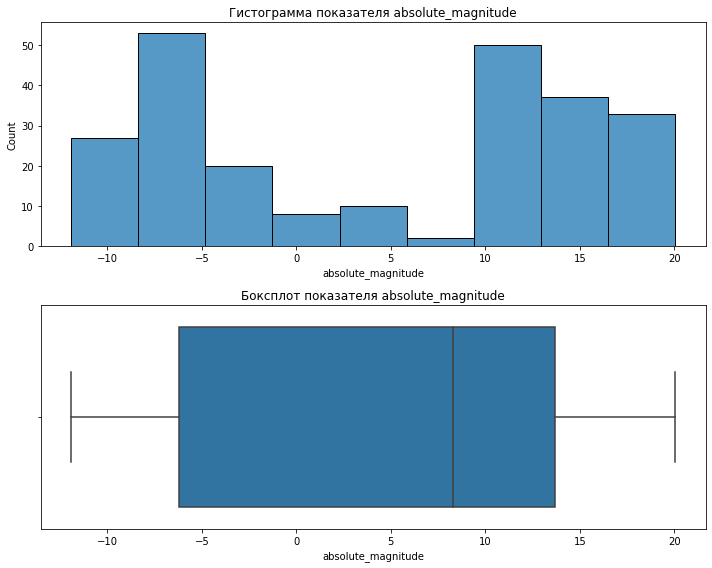

In [135]:
graph('absolute_magnitude')

### star_type

In [136]:
df.star_type.value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

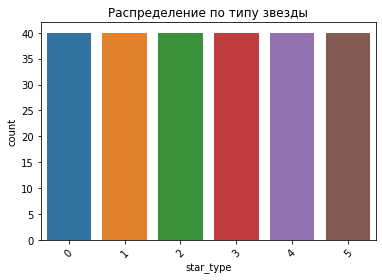

In [137]:
sns.countplot(x='star_type', data=df)
plt.xticks(rotation=45)
plt.title('Распределение по типу звезды')
plt.show()

### star_color

In [138]:
df.star_color.value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
yellowish               2
Orange                  2
Whitish                 2
White-Yellow            1
Yellowish               1
Orange-Red              1
Blue white              1
Blue                    1
Blue-White              1
Pale yellow orange      1
Name: star_color, dtype: int64

исправим цвета

In [139]:
df.star_color = df.star_color.replace(
    {'Blue White':'Blue-white', 
     'Blue white':'Blue-white', 
     'Blue-White':'Blue-white', 
     'Blue white ':'Blue-white',
     'yellow-white':'Yellow-white', 
     'Yellowish White':'Yellow-white', 
     'White-Yellow':'Yellow-white',
     'white':'White', 'Whitish':'White',
     'yellowish':'Yellow',  
     'Yellowish':'Yellow',
     'Pale yellow orange':'Orange', 
     'Orange-Red':'Orange',
     'Blue ':'Blue'
    }
) 

In [140]:
df.star_color.value_counts()

Red             112
Blue             56
Blue-white       41
Yellow-white     12
White            12
Orange            4
Yellow            3
Name: star_color, dtype: int64

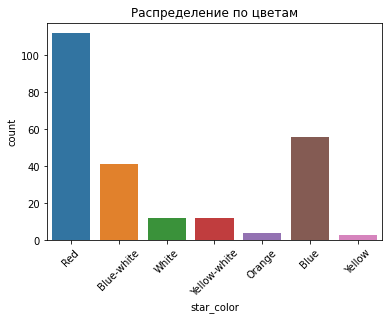

In [141]:
sns.countplot(x='star_color', data=df)
plt.xticks(rotation=45)
plt.title('Распределение по цветам')
plt.show()

### Корреляционный анализ

In [142]:
corr_matrix_phik = df.phik_matrix(
    interval_cols=df.select_dtypes(include='float').columns.to_list())

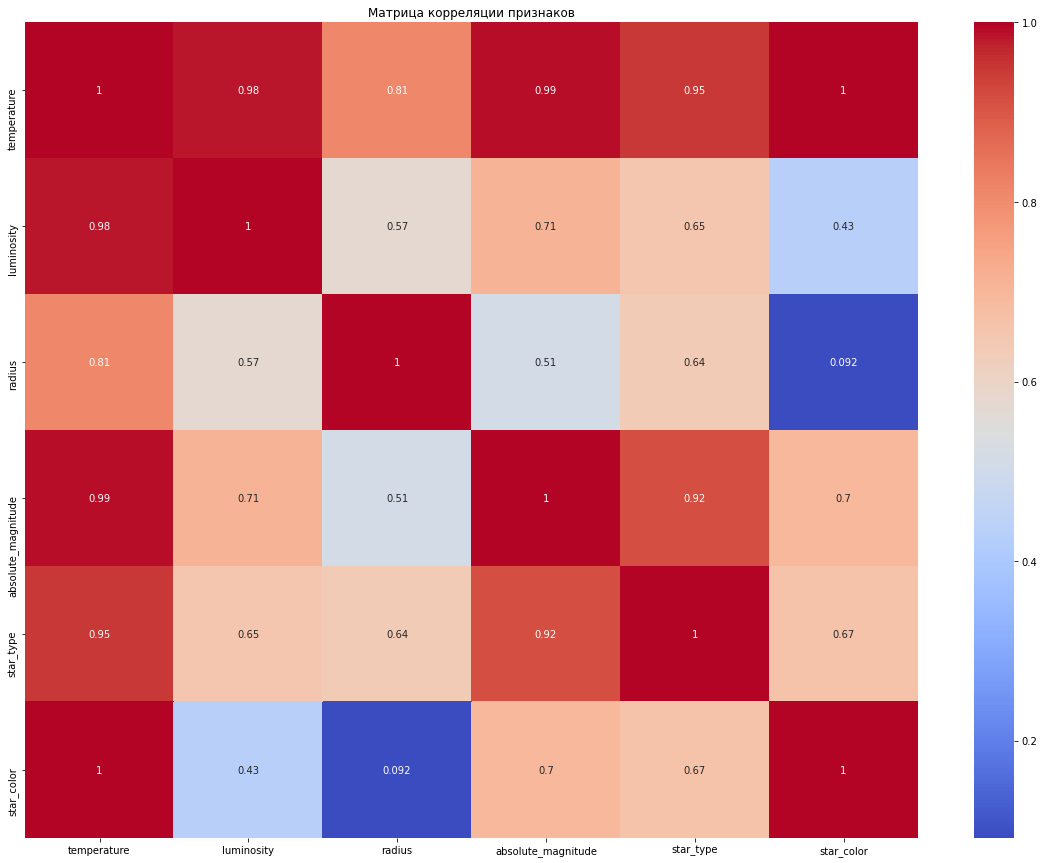

In [143]:
plt.figure(figsize=(20,15))
plt.title("Матрица корреляции признаков")
sns.heatmap(corr_matrix_phik, annot=True, cmap='coolwarm')
plt.show()

### Выводы по EDA
- пропущенных значений не обнаружено
- явных выбросов не обнаружено
- исправлены значения столбца `star_color`
- корреляционный анализ методом phik показал очень высокую корреляцию признаков

## Подготовка данных

In [144]:
#X = df.drop('temperature', axis=1)
#y = df['temperature']
y_stratify = df['star_color']
X_train, X_test, y_train_stratify, y_test_stratify = train_test_split(df.drop('star_color', axis=1), y_stratify,
     test_size=0.1, stratify=y_stratify, random_state=RANDOM_STATE)

In [145]:
X_train = X_train.assign(star_color=y_train_stratify)
X_test = X_test.assign(star_color=y_test_stratify)

In [146]:
y_train = X_train['temperature']
X_train = X_train.drop('temperature', axis=1)
y_test = X_test['temperature']
X_test = X_test.drop('temperature', axis=1)

In [147]:
ohe_columns = ['star_color', 'star_type']
num_columns = ['luminosity', 'radius', 'absolute_magnitude']

In [148]:
ohe_pipe = Pipeline(
    [
       ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
       ]
)

In [149]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [150]:
X_train_scaled = pd.DataFrame(data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out())
X_test_scaled = pd.DataFrame(data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out())

In [151]:
X_train_scaled.head()

,ohe__star_color_Blue-white,ohe__star_color_Orange,ohe__star_color_Red,ohe__star_color_White,ohe__star_color_Yellow,ohe__star_color_Yellow-white,ohe__star_type_1,ohe__star_type_2,ohe__star_type_3,ohe__star_type_4,ohe__star_type_5,num__luminosity,num__radius,num__absolute_magnitude
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.583431,-0.435462,0.990957
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.033406,3.450314,-1.470019
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.583431,-0.436899,0.897673
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.583431,-0.436896,0.718798
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.933741,1.923152,-1.312301


## Baseline

In [152]:
input_size = X_train_scaled.shape[1]  
hidden_size = 1024
num_classes = 1 
num_epochs = 100
batch_size = 16
learning_rate = 0.01

In [153]:
X_train_tensor = torch.FloatTensor(X_train_scaled.values)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.FloatTensor(X_test_scaled.values)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [154]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [155]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss() 

    def forward(self, y_pred, y_true):
        
        mse_loss = self.mse(y_pred, y_true)
        rmse_loss = torch.sqrt(mse_loss)
        return rmse_loss

In [157]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs):

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        
        model.train()
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item() * inputs.size(0)
        
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        
        model.eval()
        epoch_test_loss = 0.0
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1))
                epoch_test_loss += loss.item() * inputs.size(0)
                y_pred.extend(outputs.cpu().numpy())
        
        
        epoch_test_loss /= len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}],\
            Train Loss: {epoch_train_loss:.0f},\
            Test Loss: {epoch_test_loss:.0f}')

    return train_losses, test_losses, y_pred

In [158]:
model = NeuralNet(input_size, hidden_size, num_classes, dropout_rate=0.0)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses, test_losses, y_pred = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

Epoch [100/100],            Train Loss: 4312,            Test Loss: 4817


In [159]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()


rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')

RMSE: 5260.16


### Визуализация прогноза

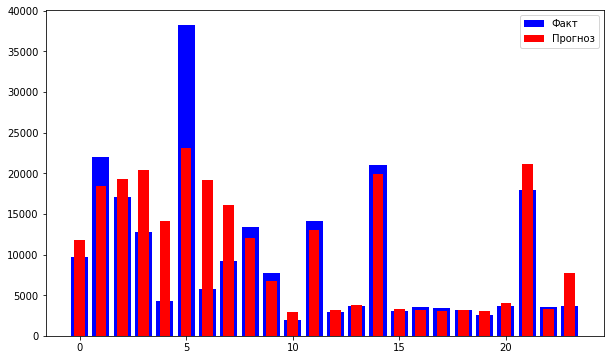

In [160]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(y_test)), y_test, color='blue', label='Факт')
plt.bar(range(len(y_pred)), pd.Series([x[0] for x in y_pred]), width = 0.5, color='red', label='Прогноз')
plt.legend()
plt.show()

## Улучшение нейронной сети

Создадим функцию в которой будем переберать:
- количество батчей
- долю дропаута
- количество эпох


In [161]:
class NeuralNetImproved(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(NeuralNetImproved, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [162]:
def hyperparameter_tuning(train_dataset,
                          test_dataset,
                          input_size,
                          hidden_sizes,
                          num_classes,
                          dropout_rates,
                          batch_sizes,
                          num_epochs_list,
                          learning_rates):

    results = []
    for dropout_rate in dropout_rates:
        for hidden_size in hidden_sizes:
            for learning_rate in learning_rates:
                for batch_size in batch_sizes:
                    for num_epochs in num_epochs_list:

            
                        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
                        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

                        
                        model = NeuralNetImproved(input_size, hidden_size, num_classes, dropout_rate=dropout_rate)

                        criterion = RMSELoss()
                        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                        train_losses, test_losses, y_pred = train_model(
                            model=model,
                            train_loader=train_loader,
                            test_loader=test_loader,
                            criterion=criterion,
                            optimizer=optimizer,
                            num_epochs=num_epochs
                        )

                        y_test = test_dataset.tensors[1].numpy()
                        rmse = root_mean_squared_error(y_test, y_pred)

                        results.append({
                            'dropout_rate': dropout_rate,
                            'hidden_size': hidden_size,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs,
                            'train_loss': train_losses[-1],  
                            'test_loss': test_losses[-1],    
                            'rmse': rmse
                        })

                        print(f"Dropout: {dropout_rate},\
                               Hidden Size: {hidden_size},\
                                  Learning Rate: {learning_rate},\
                                    Batch Size: {batch_size},\
                                          Epochs: {num_epochs},\
                                              RMSE: {rmse:.2f}")

    return results

In [165]:
input_size = X_train_scaled.shape[1]  
hidden_sizes = [512, 625]
learning_rates = [0.015, 0.016]
dropout_rates = [0.2, 0.3]
batch_sizes = [7, 16]
num_epochs_list = [100, 200]

results = hyperparameter_tuning(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    dropout_rates=dropout_rates,
    batch_sizes=batch_sizes,
    num_epochs_list=num_epochs_list,
    learning_rates=learning_rates
)

Epoch [100/100],            Train Loss: 3820,            Test Loss: 3681
Dropout: 0.2,                               Hidden Size: 512,                                  Learning Rate: 0.015,                                    Batch Size: 7,                                          Epochs: 100,                                              RMSE: 4654.00
Epoch [100/200],            Train Loss: 3603,            Test Loss: 3476
Epoch [200/200],            Train Loss: 3504,            Test Loss: 3248
Dropout: 0.2,                               Hidden Size: 512,                                  Learning Rate: 0.015,                                    Batch Size: 7,                                          Epochs: 200,                                              RMSE: 4274.62
Epoch [100/100],            Train Loss: 4358,            Test Loss: 4910
Dropout: 0.2,                               Hidden Size: 512,                                  Learning Rate: 0.015,                                

In [166]:
latest_res = pd.DataFrame(results)
latest_res.sort_values(by='rmse')

,dropout_rate,hidden_size,learning_rate,batch_size,num_epochs,train_loss,test_loss,rmse
29,0.3,625,0.016,7,200,3595.375143,3227.794449,4229.348633
15,0.2,625,0.016,16,200,4021.557237,4185.995443,4240.204590
13,0.2,625,0.016,7,200,3560.813012,3241.997579,4245.666504
7,0.2,512,0.016,16,200,3766.080874,4185.175537,4251.124023
25,0.3,625,0.015,7,200,3567.564479,3274.340729,4271.748535
1,0.2,512,0.015,7,200,3504.283751,3248.018954,4274.624512
17,0.3,512,0.015,7,200,3512.163927,3189.259542,4284.943848
4,0.2,512,0.016,7,100,3715.296963,3298.452044,4302.848633
27,0.3,625,0.015,16,200,3874.339084,4232.069092,4303.634766
21,0.3,512,0.016,7,200,3579.636200,3269.887332,4315.901855


In [167]:
pd.DataFrame(results).sort_values(by='rmse')

,dropout_rate,hidden_size,learning_rate,batch_size,num_epochs,train_loss,test_loss,rmse
29,0.3,625,0.016,7,200,3595.375143,3227.794449,4229.348633
15,0.2,625,0.016,16,200,4021.557237,4185.995443,4240.204590
13,0.2,625,0.016,7,200,3560.813012,3241.997579,4245.666504
7,0.2,512,0.016,16,200,3766.080874,4185.175537,4251.124023
25,0.3,625,0.015,7,200,3567.564479,3274.340729,4271.748535
1,0.2,512,0.015,7,200,3504.283751,3248.018954,4274.624512
17,0.3,512,0.015,7,200,3512.163927,3189.259542,4284.943848
4,0.2,512,0.016,7,100,3715.296963,3298.452044,4302.848633
27,0.3,625,0.015,16,200,3874.339084,4232.069092,4303.634766
21,0.3,512,0.016,7,200,3579.636200,3269.887332,4315.901855


## Выводы

1. Базовая модель 
- RMSE = 5626 
2. Улучшенная модель c дропаутом и перебором батчей и эпох:
- скрытые слои 625
- шаг обучения 0,016
- дропаут 0,3
- батч 7
- эпохи 200
- лучшая RMSE = 4229
3. Основным факторов повлиявшим на улучшение показателей модели является стратификация признака цвет звезды